In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
#import tensorboard
%load_ext tensorboard
#import tensorboardcolab
#from tensorboardcolab import TensorBoardColab,TensorBoardColabCallback
import lightgbm as lgb

from datetime import datetime
from packaging import version


plt.style.use('dark_background')

In [3]:
print('TensorFlow Version: ',tf.__version__)
print("GPUs Available", len(tf.config.experimental.list_physical_devices('GPU')))

device_name = tf.test.gpu_device_name()
print(device_name)

#!rm -rf ./logs/

TensorFlow Version:  2.1.0
GPUs Available 0



In [4]:
# Package ID: knb-lter-hbr.237.1 Cataloging System:https://pasta.edirepository.org.
# Data set title: Hubbard Brook Experimental Forest: 15 Minute Solar Radiation Measurements, 2014 - present.
# Data set creator:   USDA Forest Service, Northern Research Station -  
# Contact:    - Information Manager Hubbard Brook Ecosystem Study  - hbr-im@lternet.edu
# Stylesheet v1.0 for metadata conversion into program: John H. Porter, Univ. Virginia, jporter@virginia.edu      
# 
# This program creates numbered PANDA dataframes named dt1,dt2,dt3...,
# one for each data table in the dataset. It also provides some basic
# summaries of their contents. NumPy and Pandas modules need to be installed
# for the program to run. 


infile1  ="https://pasta.lternet.edu/package/data/eml/knb-lter-hbr/237/1/e4cb501c7d42fd5706e24fca91af4445".strip() 
infile1  = infile1.replace("https://","http://")
                 
dt1 =pd.read_csv(infile1 
          ,skiprows=1
            ,sep=","  
                ,quotechar='"' 
           , names=[
                    "Date",     
                    "SolRad1",     
                    "SolRad2"    ]
# data type checking is commented out because it may cause data
# loads to fail if the data contains inconsistent values. Uncomment 
# the following lines to enable data type checking
         
#            ,dtype={ 
#             'Date':'str' , 
#             'SolRad1':'float' , 
#             'SolRad2':'float'  
#        }
          ,parse_dates=[
                        'Date',
                ] 
    )
# Coerce the data into the types specified in the metadata 
# Since date conversions are tricky, the coerced dates will go into a new column with _datetime appended
# This new column is added to the dataframe but does not show up in automated summaries below. 
dt1=dt1.assign(Date_datetime=pd.to_datetime(dt1.Date,errors='coerce')) 
dt1.SolRad1=pd.to_numeric(dt1.SolRad1,errors='coerce') 
dt1.SolRad2=pd.to_numeric(dt1.SolRad2,errors='coerce') 
      
print("Here is a description of the data frame dt1 and number of lines\n")
print(dt1.info())
print("--------------------\n\n")                
print("Here is a summary of numerical variables in the data frame dt1\n")
print(dt1.describe())
print("--------------------\n\n")                
                         
print("The analyses below are basic descriptions of the variables. After testing, they should be replaced.\n")                 

print(dt1.Date.describe())               
print("--------------------\n\n")
                    
print(dt1.SolRad1.describe())               
print("--------------------\n\n")
                    
print(dt1.SolRad2.describe())               
print("--------------------\n\n")
                    
                    
                 

infile2  ="https://pasta.lternet.edu/package/data/eml/knb-lter-hbr/237/1/fe1bf735842ffdd9728104e6ab2f07dd".strip() 
infile2  = infile2.replace("https://","http://")
                 
dt2 =pd.read_csv(infile2 
          ,skiprows=1
            ,sep=","  
                ,quotechar='"' 
           , names=[
                    "Date",     
                    "SolRad"    ]
# data type checking is commented out because it may cause data
# loads to fail if the data contains inconsistent values. Uncomment 
# the following lines to enable data type checking
         
#            ,dtype={ 
#             'Date':'str' , 
#             'SolRad':'float'  
#        }
          ,parse_dates=[
                        'Date',
                ] 
    )
# Coerce the data into the types specified in the metadata 
# Since date conversions are tricky, the coerced dates will go into a new column with _datetime appended
# This new column is added to the dataframe but does not show up in automated summaries below. 
dt2=dt2.assign(Date_datetime=pd.to_datetime(dt2.Date,errors='coerce')) 
dt2.SolRad=pd.to_numeric(dt2.SolRad,errors='coerce') 
      
print("Here is a description of the data frame dt2 and number of lines\n")
print(dt2.info())
print("--------------------\n\n")                
print("Here is a summary of numerical variables in the data frame dt2\n")
print(dt2.describe())
print("--------------------\n\n")                
                         
print("The analyses below are basic descriptions of the variables. After testing, they should be replaced.\n")                 

print(dt2.Date.describe())               
print("--------------------\n\n")
                    
print(dt2.SolRad.describe())               
print("--------------------\n\n")
                    
                    
                






Here is a description of the data frame dt1 and number of lines

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164833 entries, 0 to 164832
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           164833 non-null  datetime64[ns]
 1   SolRad1        164833 non-null  float64       
 2   SolRad2        164833 non-null  float64       
 3   Date_datetime  164833 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2)
memory usage: 5.0 MB
None
--------------------


Here is a summary of numerical variables in the data frame dt1

             SolRad1        SolRad2
count  164833.000000  164833.000000
mean      119.483206     119.809603
std       220.774879     221.288786
min         0.000000       0.000000
25%         0.000000       0.000000
50%         1.838000       1.863000
75%       115.800000     116.100000
max      1128.000000    1130.000000
--------------------


The analyses be

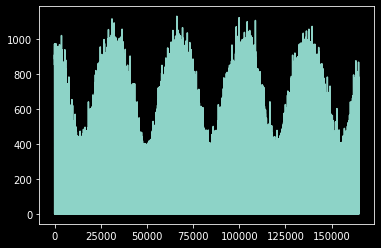

In [5]:
plt.plot(dt1['SolRad1'])
plt.show()


In [4]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)


In [5]:
# Initial parameters for prediction
DATASPLIT = int(np.floor(0.9*31189))
HISTORYLENGTH = 12
PREDICTIONLENGTH = 0

# Clean NaN values
dt1.dropna(inplace=True)


# Select Data Column for initial pass
solRad = dt1['SolRad1']
solRad.index = dt1['Date']



print('SolRad Variable size: ', solRad.shape)

solRad = solRad.values
print('SolRad Variable size: ', solRad.shape)


# standardize data
solRad_mean = solRad[:DATASPLIT].mean()
solRad_std = solRad[:DATASPLIT].std()

stRad = (solRad - solRad_mean) / solRad_std

# make sure it's 1 dimensional before splitting data
print(stRad.shape)



# prep the data and split into train / test
xTrain, yTrain = univariate_data(stRad,0,DATASPLIT,HISTORYLENGTH,PREDICTIONLENGTH)

xTest, yTest = univariate_data(stRad,DATASPLIT+1,None,HISTORYLENGTH,PREDICTIONLENGTH)


SolRad Variable size:  (164833,)
SolRad Variable size:  (164833,)
(164833,)


In [13]:
xTest = xTest.reshape((xTest.shape[0],xTest.shape[1]))
xTrain = xTrain.reshape((xTrain.shape[0],xTrain.shape[1]))

print(xTest.shape)
print(yTest.shape)

(136750, 12)
(136750,)


In [6]:
# Windowing the data (NOt using anymore, will switch to continuous data stream)

BATCHSIZE = 256
BUFFERSIZE = 10000
EPOCHS = 150
ITERATIONS = 300

trainingData = tf.data.Dataset.from_tensor_slices((xTrain, yTrain))
trainingData = trainingData.cache().shuffle(BUFFERSIZE).batch(BATCHSIZE).repeat()

testData = tf.data.Dataset.from_tensor_slices((xTest, yTest))
testData = testData.batch(BATCHSIZE).repeat()

print(trainingData)
print(testData)

<RepeatDataset shapes: ((None, 12, 1), (None,)), types: (tf.float64, tf.float64)>
<RepeatDataset shapes: ((None, 12, 1), (None,)), types: (tf.float64, tf.float64)>


In [7]:
logdir="logs\\fit\\" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq = 1)

def meanSquareError(y_true,y_pred):
    return keras.backend.mean((y_true - y_pred)**2)

In [8]:
checkpointPath = "checkpoints/cp.ckpt"
checkpointDirectory = os.path.dirname(checkpointPath)

cp_callback = keras.callbacks.ModelCheckpoint(filepath = checkpointPath,save_weights_only = True,
verbose = 1)

In [9]:
%tensorboard --logdir logs/fit --host localhost --port 6006

Launching TensorBoard...

In [5]:
ts_input = keras.Input(shape = (12,1))
x=keras.layers.Dense(units=1,activation='relu')(ts_input)
x = keras.layers.Flatten()(x)
#x=keras.layers.Dropout(0.2)(x)
x=keras.layers.Dense(units=12,activation='relu')(x)
x = keras.layers.Flatten()(x)
#x=keras.layers.Dropout(0.2)(x)
x=keras.layers.Dense(units=6,activation='relu')(x)
x = keras.layers.Flatten()(x)
outputs = keras.layers.Dense(units = 1, activation = 'linear')(x)

denseModel = keras.Model(inputs = ts_input, outputs = outputs)

adamOpt = keras.optimizers.Adam(lr=0.0005)

denseModel.compile(optimizer = adamOpt, loss = 'mse', metrics = ['mae','mse'])

lstmModel.summary()



NameError: name 'denseModel' is not defined

In [1]:
ts_input = keras.Input(shape = (12,1))
x=keras.layers.LSTM(units=1)(ts_input)
#x=keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(1, activation = 'linear')(x)

lstmModel = keras.Model(inputs = ts_input, outputs = outputs)
adamOpt = keras.optimizers.Adam(lr=0.0005)

lstmModel.compile(optimizer = adamOpt, loss = 'mse', metrics = ['mae','mse'])

lstmModel.summary()

NameError: name 'keras' is not defined

In [10]:
ts_input = keras.Input(shape = (12,1))
x=keras.layers.LSTM(units=1,return_sequences=True)(ts_input)
#x=keras.layers.Dropout(0.2)(x)
x = keras.layers.LSTM(units=1)(x)
outputs = keras.layers.Dense(1, activation = 'linear')(x)

lstmModel = keras.Model(inputs = ts_input, outputs = outputs)
adamOpt = keras.optimizers.Adam(lr=0.0005)

lstmModel.compile(optimizer = adamOpt, loss = 'mse', metrics = ['mae','mse'])

lstmModel.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 12, 1)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 12, 1)             12        
_________________________________________________________________
lstm_1 (LSTM)                (None, 1)                 12        
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 26
Trainable params: 26
Non-trainable params: 0
_________________________________________________________________


In [11]:
lstmModel.fit(trainingData,epochs = EPOCHS, steps_per_epoch = ITERATIONS, validation_data=testData,validation_steps=50,callbacks = [cp_callback,tensorboard_callback])

 22ms/step - loss: 0.0630 - mae: 0.0984 - mse: 0.0629 - val_loss: 0.1454 - val_mae: 0.1741 - val_mse: 0.1454
Epoch 87/150
297/300 [============================>.] - ETA: 0s - loss: 0.0639 - mae: 0.1004 - mse: 0.0641
Epoch 00087: saving model to checkpoints/cp.ckpt
300/300 [==============================] - 7s 22ms/step - loss: 0.0637 - mae: 0.1001 - mse: 0.0638 - val_loss: 0.1450 - val_mae: 0.1749 - val_mse: 0.1450
Epoch 88/150
299/300 [============================>.] - ETA: 0s - loss: 0.0617 - mae: 0.0981 - mse: 0.0617
Epoch 00088: saving model to checkpoints/cp.ckpt
300/300 [==============================] - 7s 22ms/step - loss: 0.0617 - mae: 0.0981 - mse: 0.0616 - val_loss: 0.1449 - val_mae: 0.1729 - val_mse: 0.1449
Epoch 89/150
299/300 [============================>.] - ETA: 0s - loss: 0.0627 - mae: 0.0986 - mse: 0.0627
Epoch 00089: saving model to checkpoints/cp.ckpt
300/300 [==============================] - 7s 22ms/step - loss: 0.0627 - mae: 0.0986 - mse: 0.0627 - val_loss: 0.14

In [12]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  #time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  nPts = plot_data[0].shape[0]
  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(nPts, plot_data[i], marker[i], markersize=10,label=labels[i])
    else:
      plt.plot(range(0,nPts), plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([0, nPts+2])
  plt.xlabel('Time-Step')
  return plt

def create_time_steps(length):
  return list(range(-length, 0))


<TakeDataset shapes: ((None, 12, 1), (None,)), types: (tf.float64, tf.float64)>


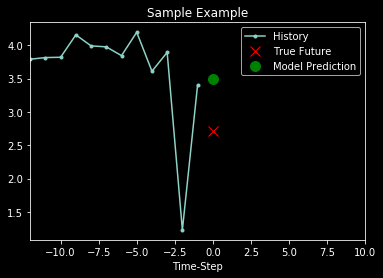

In [25]:
show_plot([xTrain[0], yTrain[0], 3.5], 0, 'Sample Example')
print(trainingData.take(1))

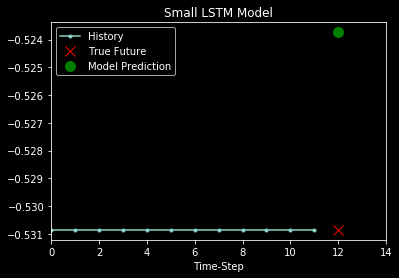

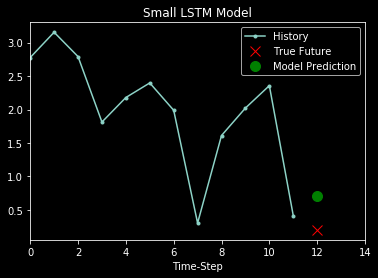

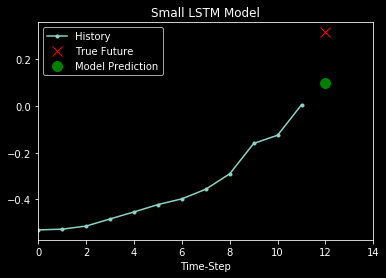

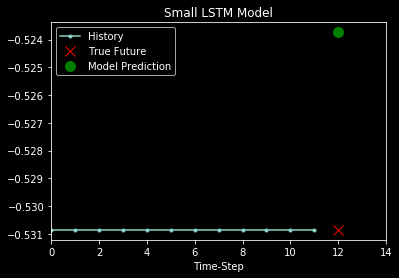

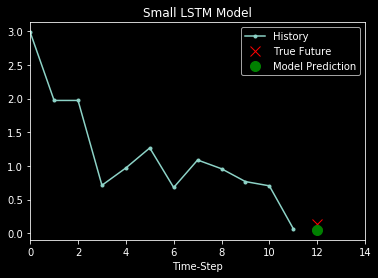

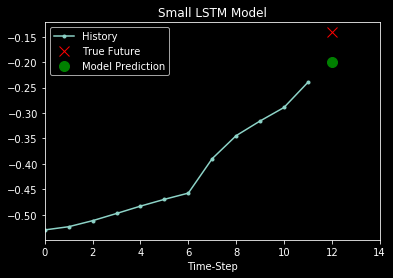

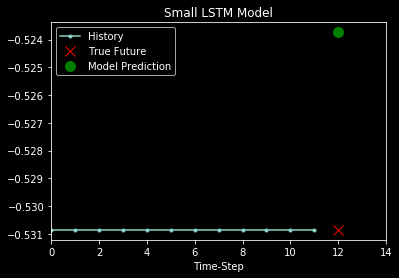

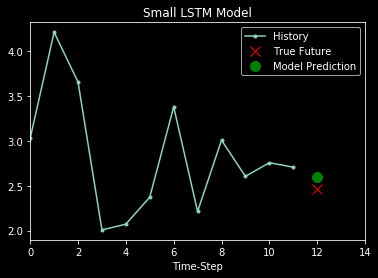

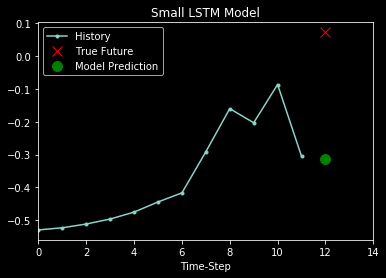

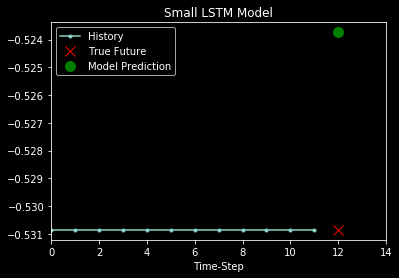

In [14]:
#lstmModel.summary()
predictionResiduals = np.array([],dtype = np.float32)

for x,y in testData.take(10):
    #print(f'The shape of the first input is {x.numpy().shape}')
    #print(f'The prediction is {lstmModel.predict(x)}\n')
    #print(f'The shape of y {y.shape}')
    yPred = lstmModel.predict(x)[0]
    plot = show_plot([x.numpy()[0,:],y[0].numpy(),yPred],0,'Small LSTM Model')
    resid = y[0] - yPred
    predictionResiduals = np.append(predictionResiduals,resid)
    plot.show()

In [15]:
lstmModel.save('saved2LSTMModel')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved2LSTMModel\assets


In [39]:
resid_rmse = np.sqrt(np.mean(np.dot(predictionResiduals.transpose(),predictionResiduals)))
resid_std = np.std(predictionResiduals)

print(f'The mean prediction RMSE is {resid_rmse}')
print(f'The mean prediction SD is {resid_std}')

The mean prediction RMSE is 2.830706497725124
The mean prediction SD is 0.2827799129471972
